**This notebook is intended as a walkthrough for beginners to learn how to use boosted tree models for regression.  Some, but not all, key concepts are explored.  Although neural networks are very popular and sometimes superior, they are often not necessary or can even be inferior to a more basic approach.**

**A high level (and oversimplified) way of understanding these models is that they are basically building a series of decision trees (think CART) and then taking a weighted average of their results.  There is actually way more to it than that and it is worth taking the time to truly understand what is going on "under the hood".  However, that basic understanding is enough to build useful models.**

**First it is necessary to load the following packages.**

In [32]:
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import matthews_corrcoef
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from decimal import Decimal


**A list of column names is constructed.  It will be applied as the data is being read.**

In [33]:

cols = ['age', 'workclass', 'fnlwgt', 'education', 'education_num',
        'marital_status', 'occupation', 'relationship', 'ethnicity',
        'gender', 'capital_gain', 'capital_loss', 'hours_per_week',
        'country_of_origin', 'income']

**Read in data as a pandas data frame.  This is a well known pulic data set.**

In [34]:
raw_data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
                       names = cols)


**As long as the data is not too large, it is a good idea (especially for beginners) to make a copy of the raw data.  This will allow easy checking of the before and after state of  the data after different manipulations are performed.  If this were a production pipeline, this would probably not be done.**

In [35]:
data = raw_data


**Now check that the data looks as expected at this point.**

In [36]:
data.head()


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,ethnicity,gender,capital_gain,capital_loss,hours_per_week,country_of_origin,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [37]:
data.columns


Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'ethnicity', 'gender',
       'capital_gain', 'capital_loss', 'hours_per_week', 'country_of_origin',
       'income'],
      dtype='object')

**A model which predicts age will be built.  The age field should be examined.**

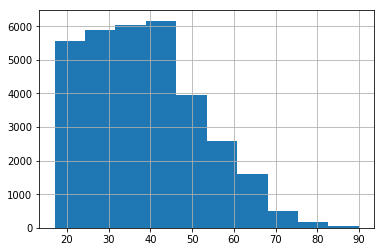

In [38]:
data.age.hist()

**Gradient boosting regression does not require that the target be normally distributed.  However, it is interesting to observe that a log transformation does result in a normally distributed target.  A good exercise would be to train and validate the model both ways (natural and after log transformation) to see if it makes any difference on the results.  Remember to transform the log model back to natural scale for comparison.**

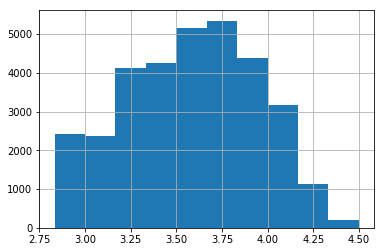

In [39]:
np.log(data.age).hist()


**Now it is time to do some feature engineering.**

**Then income field has two categorical values.  The algorithm only takes numerical values.  Since there are only two classes for income, it can simply be coded as 1 for > 50K and 0 for <= 50K.  This will allow the model to use this information in a format it can handle.**

In [40]:
income_ = np.zeros(len(data))

for i in range(len(data)):
    if data.income.values[i] == ' >50K':
        income_[i] = 1
        
data['income_'] = income_

In [41]:
data.income.value_counts()

 <=50K    24720
 >50K      7841
Name: income, dtype: int64

In [42]:
data.income_.value_counts()

0.0    24720
1.0     7841
Name: income_, dtype: int64

**The gender column currently contains text.  It will need to undergo a transformation.  It will be coded as as 1 for female and 0 for male.**

In [43]:
gender_num = np.zeros(len(data))

for i in range(len(data)):
    if data.gender.values[i] == ' Female':
        gender_num[i] = 1
        
data['gender_num'] = gender_num

In [44]:
data.gender.value_counts()

 Male      21790
 Female    10771
Name: gender, dtype: int64

In [45]:
data.gender_num.value_counts()

0.0    21790
1.0    10771
Name: gender_num, dtype: int64


**The workclass column has text padded with white space.  It will make life easier if we strip out the wihite space.  We will also rename the classes because they contain symbols that will not work as column names. Some classes are collapsed as they are similar.  In this case, the assumption is that information is not lost by collapsing and there is increased predictive power in unifying these categories.  This is not always the case.  Careful thought should be given to collapsing categorical features and testing of different collapsing schema should be considered.**

In [46]:
data.workclass.value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64

In [47]:
data.workclass = data.workclass.str.strip()

data['workclass_buckets'] = data.workclass.replace(['Private' #begin old names
                                                    , 'Self-emp-not-inc'
                                                    , 'Local-gov'
                                                    , '?'
                                                    , 'State-gov'
                                                    , 'Self-emp-inc'
                                                    , 'Federal-gov'
                                                    , 'Without-pay'
                                                    , 'Never-worked'] 
                                                    , ['pvt' #begin new names
                                                    , 'self'
                                                    , 'govt'
                                                    , 'other'
                                                    , 'govt'
                                                    , 'self'
                                                    , 'govt'
                                                    , 'other'
                                                    , 'other'])

**Check that workclass collapsed properly.**

In [48]:
data.workclass_buckets.value_counts()

pvt      22696
govt      4351
self      3657
other     1857
Name: workclass_buckets, dtype: int64

**Since these features are purely categorical (no meaningful numeric assignment can be made), they will need to be one hot encoded.**

In [49]:
data = pd.concat([data, pd.get_dummies(data['workclass_buckets'], prefix = 'wcb')], axis = 1)

**Check that the encoding was performed properly.**

In [50]:
data[['workclass', 'workclass_buckets',  'wcb_govt', 'wcb_self', 'wcb_pvt', 'wcb_other']].head(10)

,workclass,workclass_buckets,wcb_govt,wcb_self,wcb_pvt,wcb_other
0,State-gov,govt,1,0,0,0
1,Self-emp-not-inc,self,0,1,0,0
2,Private,pvt,0,0,1,0
3,Private,pvt,0,0,1,0
4,Private,pvt,0,0,1,0
5,Private,pvt,0,0,1,0
6,Private,pvt,0,0,1,0
7,Self-emp-not-inc,self,0,1,0,0
8,Private,pvt,0,0,1,0
9,Private,pvt,0,0,1,0


**The same process would need to be performed to include ethnicity.  A good exercise for beginners would be to go through the process of one hot encoding ethnicity and adding it to the model.**

**Now education_num will be examined.  There is also an education field which is categorical.  However, if the education_num values have numerical meaning, this would likely be a more powerful predictor.  A quick check will reveal if larger values of education_num are indicative of higher levels of education.**

In [51]:

data[['education_num', 'education']].groupby(['education_num', 'education']).count()

,
education_num,education
1,Preschool
2,1st-4th
3,5th-6th
4,7th-8th
5,9th
6,10th
7,11th
8,12th
9,HS-grad


**This results yields two important findings.  Firstly, education_num has a one to one mapping with education.  This was expected.  But as with all things data, it was still worth checking.  Also, it is pretty clear that the education_num values become larger as education level increases.  This means that the numerical values will be useful for modeling.**

**At this point feature engineering will stop and data will be split into a train and test set.  For this model, a 75%/25% split was chosen.  This is somewhat arbitrary for this application.  For other applications, there can be practical reasons why the data may need to be split differently.  In the absence of those types of constraints, most people will use something between 60%/40% and 80%/20%.  It is also worth noting that there is certainly opportunity to build more sophisticated features with this data set.  The feature engineering step is an opportunity to be creative and try new things.  In this case, some basic features were built for demonstration purposes.**

In [52]:
train, test = train_test_split(data, test_size = 0.25)

In [53]:
train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,ethnicity,gender,...,hours_per_week,country_of_origin,income,income_,gender_num,workclass_buckets,wcb_govt,wcb_other,wcb_pvt,wcb_self
1926,30,Private,204374,Bachelors,13,Never-married,Sales,Not-in-family,White,Male,...,48,United-States,<=50K,0.0,0.0,pvt,0,0,1,0
9915,29,Private,122000,Some-college,10,Never-married,Sales,Not-in-family,White,Male,...,60,United-States,<=50K,0.0,0.0,pvt,0,0,1,0
14636,41,Local-gov,248406,HS-grad,9,Separated,Transport-moving,Own-child,White,Male,...,40,United-States,<=50K,0.0,0.0,govt,1,0,0,0
13905,47,Local-gov,162187,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,...,40,United-States,>50K,1.0,0.0,govt,1,0,0,0
4353,63,Private,127363,Some-college,10,Married-civ-spouse,Prof-specialty,Wife,White,Female,...,12,United-States,<=50K,0.0,1.0,pvt,0,0,1,0


In [54]:
test.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,ethnicity,gender,...,hours_per_week,country_of_origin,income,income_,gender_num,workclass_buckets,wcb_govt,wcb_other,wcb_pvt,wcb_self
30622,24,Private,128061,HS-grad,9,Never-married,Other-service,Own-child,White,Female,...,15,United-States,<=50K,0.0,1.0,pvt,0,0,1,0
14133,32,Private,107793,HS-grad,9,Divorced,Other-service,Own-child,White,Male,...,40,United-States,<=50K,0.0,0.0,pvt,0,0,1,0
7220,27,Private,220754,Doctorate,16,Never-married,Adm-clerical,Own-child,White,Female,...,40,United-States,<=50K,0.0,1.0,pvt,0,0,1,0
13264,38,Private,149347,Some-college,10,Divorced,Sales,Not-in-family,White,Male,...,60,United-States,<=50K,0.0,0.0,pvt,0,0,1,0
10391,43,Private,198316,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,...,40,United-States,<=50K,0.0,0.0,pvt,0,0,1,0


**A list of features is assembled to control the inputs to the model.  The list is used to subset down to only the columns that will be used as features.  Editing this list will alter which features are used as inputs to the model.  For now, the features previously examined/constructed will be used as well as a few other columns that seem like reasonable predictors.**

In [55]:
features = ['wcb_govt'
            , 'wcb_self'
            , 'wcb_pvt'
            , 'wcb_other'
            , 'education_num'
            , 'income_'
            , 'gender_num'
            , 'capital_gain'
            , 'capital_loss'
            , 'hours_per_week']


**Now the data will be split again.  The built in algorithm wants the features (X) and the target (y) in separate arrays.  Both the train and test data will be split in this way so they can be input into the function.**

In [56]:
X_train = np.array(train[features])
X_test = np.array(test[features])
y_train = np.array(train['age'])
y_test = np.array(test['age'])

**A parameter grid will be set up to help tune the hyperparameters.  The numbers used are a reasonable starting point for this relatively small data set.  There are definitely more hyperparameters that could be added but these seem to make the most difference in terms of model performance.  That being said, as long as the settings are reasonable, small adjustments of these do not make much difference.  Feature engineering is far more important.  Anyway, an explanation of the hyperparameters chosen:**

**n_estimators - This controls the number of separate trees that are built.  Remember, this model is basically just building a set of decision trees and taking a weighted average of their output.  If there are complex relationships to model, more trees may be necessary.  Also note that a model with more trees will generally demand a slower learning rate.  The bottom line is that if the model is underfit, more trees should be added.  If it is overfit, the number of trees should be decreased.**


**learning_rate - This controls how quickly the cost function is optimized.  It is also referred to as shrinkage.  As stated above, the learning rate should decrease as model complexity increases.  Basic models can converge quickly (high learning rate) whereas complex models should be given time to learn relationships (low learning rate).  The bottom line here is that if the model is underfit, slow down (decrease) the learning rate.  If it is overfit, speed up (increase) the learning rate.**


**max_depth - This controls the depth of each individual decision tree and therefore controls the level of interactions that can be modeled.  Unnecessarily deep trees can lead to overfitting, but a complex feature space may demand deeper trees.**

**One strategy for tuning these is to start with a high range of values and large steps between values to cut down on the number of iterations.  After testing those values, the best iteration(s) can be determined and a tighter range with smaller steps can be tested for a more focused paramter space.**

In [57]:
param_grid_gbm = {
    'n_estimators': [20, 50, 100]
    , 'learning_rate': [.01, .05, .1]
    , 'max_depth': [2, 3, 4]
}

**The next three commands define the model type, set up the grid search across the chosen hyperparameters, and train the model respectively.**

In [58]:
model = ensemble.GradientBoostingRegressor()
gs_gbm = GridSearchCV(estimator = model
                     , param_grid = param_grid_gbm)
gs_gbm.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [20, 50, 100], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

**The code below will display the best parameterization for the training set.  Keep in mind that this may not necessarily be the best model.  If the algorithm has overfit on the training set, the model will not generalize well to the validation set.  Experience helps someone to get a "feel" for how this is going.  The only replacement for experience is meticulous attention to model performance on both train and test data sets.  The model should perform equally well on both sets.**

In [60]:
print(gs_gbm.best_params_)

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}


**Now the best parameterization will be used to train a model.  The following cells will show the root mean squared error for the train and test data sets.  Taking the square root of the MSE yields an interpretable result.  Roughly, it tells how far off the predictions are on average.**

In [62]:
best_gbm = gs_gbm.best_estimator_
best_gbm.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [66]:
y_pred_train = best_gbm.predict(X_train)
np.sqrt(mean_squared_error(y_train, y_pred_train))

11.978749019983814

In [67]:
y_pred_test = best_gbm.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred_test))

12.181079376478248

**As stated above, these scores should be close.  Unless this was run with a very unusual random initialization or some type of error, the scores for this model will be similar.  A test run showed approximately 12 for both the train and test sets.  Basically, on average, the model is off by 12 years.  This is not very good.  Perhaps new features need to be built.  It may also be possible that this data simply does not support building an accurate model.  Taking a more focused look at what the model is doing may help to guide next steps.**

**In this era of "black boxes" and automation, it is still important to understand what the model is doing and how it is making decisions.  GBMs are not as complex as neural nets, but it is still difficult to unpack the model and see the direct effect.  For example, the coefficients cannot simply be ported to an Excel sheet and used to calculate predictions like logistic regression.  But feature importance and partial dependence plots can give us a peak "under the hood".  They do not define exactly what the model is doing.  But they do indicate the effect a model will have on data given the inputs.**

**Feature importance reveals which predictors are having the greatest impact on making accurate predictions.  The mathematical definition is not hard to find, but it is not really important to this tutorial.  The most important thing to understand is that the feature importances will always add to 100.  Therefore, it gives no objective information about the relationship between a feature and the target.  Rather, it shows which are most important within the context of the model.  Features with low or no importance should probably be removed as they are just wasting computational resources and could even contribute to overfitting of the model.**

**The code below extracts feature importance and displays them.**

In [68]:
imp = list(np.round(best_gbm.feature_importances_*100, decimals = 1))
importance = [float(Decimal("%.1f" % e)) for e in imp]
fi = pd.DataFrame({'features': features
                  , 'importance': importance})
fi.sort_values(['importance'], ascending = False)

,features,importance
4,education_num,26.3
9,hours_per_week,25.1
7,capital_gain,15.2
8,capital_loss,9.9
5,income_,7.8
3,wcb_other,4.6
2,wcb_pvt,3.7
1,wcb_self,3.2
6,gender_num,2.4
0,wcb_govt,1.8


**These results are interesting.  It makes sense that education level would be a good predictor of age.  Hours per week also makes some sense.  However, those generally remain constant after a certain age.  It will be interesting to further examine those relationships.  It is also worth noting that this is not a great model to begin with.  There is 100% worth of feature importance to go around.  So all we really know is that those were better predictors than the other features.  It does not mean that they are objectively great predictors.**

**Partial dependence plots show the marginal effect of each predictor on the target.  They do so by getting the model output for every permutation of inputs for all other predictors at fixed values of the predictor being plotted and taking an average.  Think about integrating to find the marginal distribution of one random variable from a join distribution.  Same idea.  For numerical predictors, it is useful to examine whether it is a positive or negative relationship.  The one hot encoded predictors will simply show the impact of the 1 or 0 case as they are coded.  If relationships do not make sense, it would be wise to try to determine why counterintuitive relationships are being modeled.  It is also wise to verify that relationships are similar when partical dependence plots are constructed for both the train and test data sets.**

**The code below will create partial dependence plots for all predictors.  Note that the y-axis displays the output of the logit function.  It can easily be converted to a probability for more interpretable results.  However, the plots will look exactly the same so this format is sufficient.**

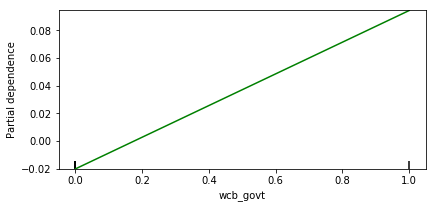

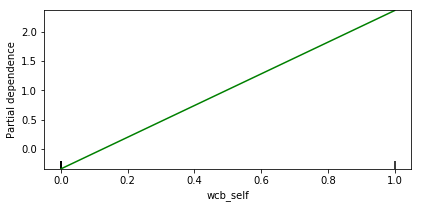

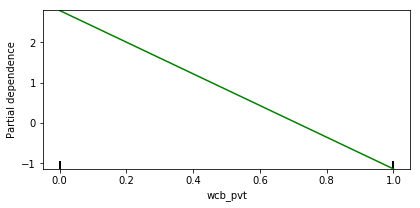

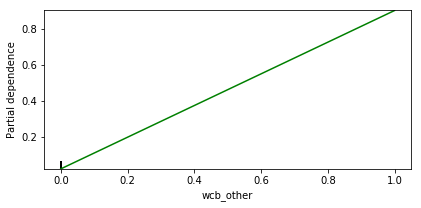

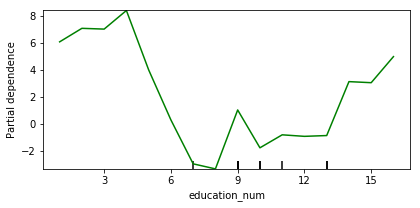

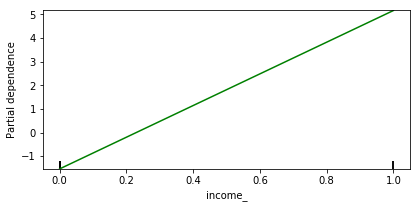

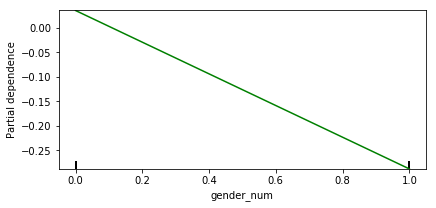

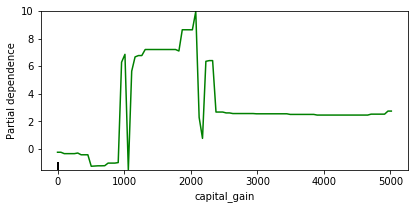

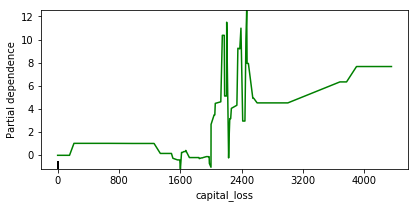

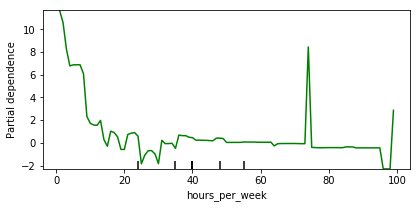

In [69]:
for i in range(len(features)):
    plot_partial_dependence(best_gbm
                           , X_train
                           , features = [i]
                           , feature_names = features)

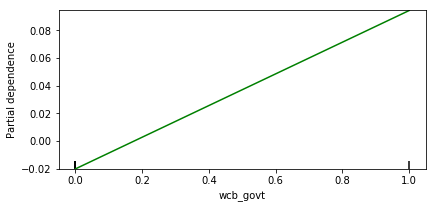

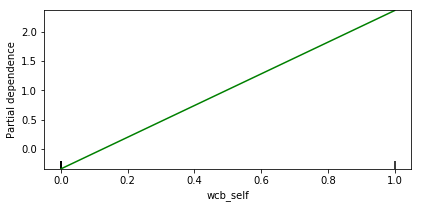

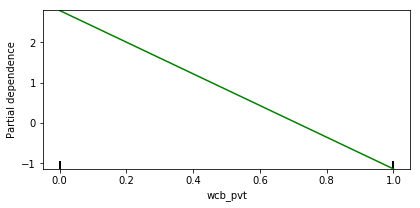

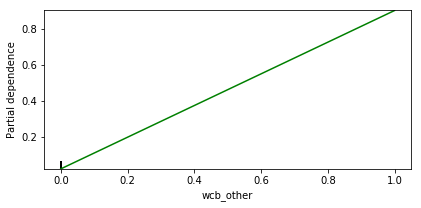

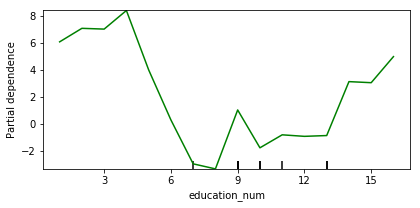

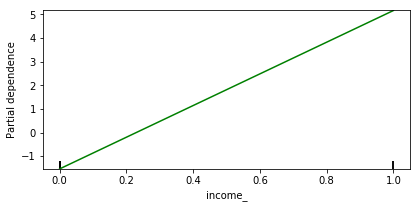

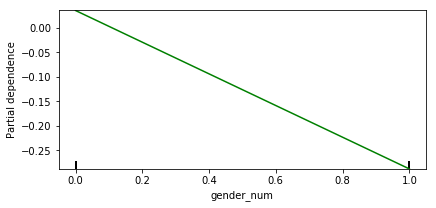

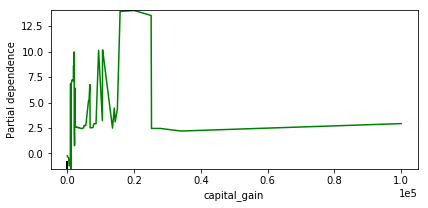

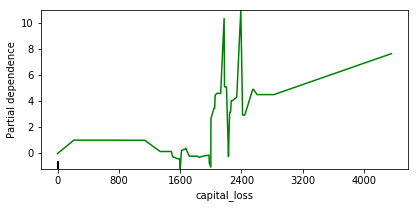

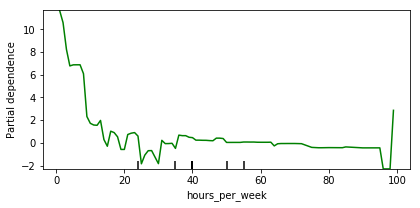

In [70]:
for i in range(len(features)):
    plot_partial_dependence(best_gbm
                           , X_test
                           , features = [i]
                           , feature_names = features)

**This is disappointing.  The education and hours per week relationships do not make a lot of sense.  This could be due to overfitting.  Adjusting hyperparameters could help.  This could also be a case where the plots are misleading.  Flooring and capping predictors might help to produce more sane output.  That is not a beginner's level topic but it is worth exploring for those wanting to improve this model.  As always, building better features would also likely help a lot.**

**Hopefully this has been a useful beginner's tutorial.  Anyone can build useful machine learning models as long as some basic principles are understood.**